# Neuromatch Academy: Week 3, Day 4, Tutorial 3 (Bonus)
# Deep Learning: Building and Evaluating Normative Encoding Models

**Content creators**: Jorge A. Menendez, Yalda Mohsenzadeh, Carsen Stringer

**Content reviewers**: Roozbeh Farhoodi, Madineh Sarvestani, Kshitij Dwivedi, Spiros Chavlis, Ella Batty, Michael Waskom


---
#Tutorial Objectives


In this tutorial, we'll be using deep learning to build an encoding model of the visual system, and then compare its internal representations to those observed in neural data.

Importantly, the encoding model we'll use here is different from the encoding models used in Tutorial 2. Its parameters won't be directly optimized to fit the neural data. Instead, we will optimize its parameters to solve a particular visual task that we know the brain can solve. We therefore refer to it as a "normative" encoding model, since it is optimized for a specific behavioral task.

To then evaluate whether this normative encoding model is actually a good model of the brain, we'll analyze its internal representations and compare them to the representations observed in mouse primary visual cortex. Since we understand exactly what the encoding model's representations are optimized to do, any similarities will hopefully shed light on why the representations in the brain look the way they do.

More concretely, our goal will be learn how to:
* Visualize and analyze the internal representations of a deep network
* Quantify the similarity between distributed representations in a model and neural representations observed in recordings, using Representational Similarity Analysis (RSA)

Video available at https://youtube.com/watch?v=KlXtKJCpV4I


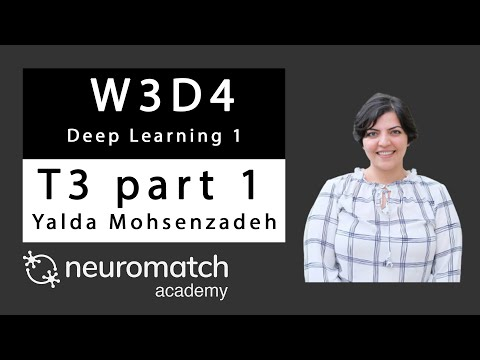

In [1]:
#@title Video 1: Deep convolutional network for orientation discrimination
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="KlXtKJCpV4I", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 1:

- use
deep neural networks as encoding and decoding models to extract information from neural activity patterns
or fit neural networks to neural responses from the brain.

- In this tutorial, use deep neural networks as models of the visual system.
We are going to train deep neural networks to perform a visual task
that we know the brain is capable of doing, for example object recognition.
Then, we look at the internal unit activation patterns and their representations and we compare them with the
neural representations of the brain.
Today, we are going to use a simple task an orientation discrimination task.
In this task, given a reference orientation, for example grating patterns with a vertical orientation,
the task is to determine whether a presented grating stimulus is oriented to the left or to the right.
We are going to train a deep neural network to perform this task, and then
compare its representations with the neural activity patterns that we have from mouse V1 region.
For this, we designed a neural network with this architecture.
It includes a convolutional layer followed by a pooling layer and then a fully connected layer and eventually an
output node. Please note that the input to this neural net are images of the
grating patterns in the stimulus cell and the output is the prediction of probability of a stimulus tilted to the right.

- POOLING: It's a simple operation that yields stability
with regards to small translations in the image and this is desirable for vision.
So, in this operation, for each patch of the 2D array, you would compute
one output, which is the max pooling of these elements or
mean pooling of this patch basically.

- First, it will initialize the convolutional neural network.
Then you would generate the training data over 1000 samples of grating patterns,
oriented from -90 degree to +90 degree with this grating function.
The output - tilt - is the labels, which is one for gratings tilted to right,
and zero for gratings sorted to the left.
Then you use this training data and their corresponding label to train the network
with a stochastic gradient descent.

---
# Setup

**Don't forget to execute the hidden cells below!**

In [ ]:
import numpy as np
from scipy.stats import zscore
import matplotlib as mpl
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
#@title Data retrieval and loading
import os
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Figure Settings

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#@title Helper Functions

def load_data(data_name=fname, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaging. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # only use stimuli <= 180
  resp_binned = resp_binned[stimuli_binned <= 180]
  stimuli_binned = stimuli_binned[stimuli_binned <= 180]

  stimuli_binned -= 90  # 0 means vertical, -ve means tilted left, +ve means tilted right

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor

def grating(angle, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating stimulus

  Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  angle = np.deg2rad(angle)  # transform to radians

  wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5

  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)


def show_stimulus(img, ax=None):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img, cmap=mpl.cm.binary)
  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)


class CNN(nn.Module):
  """Deep convolutional network with one convolutional + pooling layer followed
  by one fully connected layer

  Args:
    h_in (int): height of input image, in pixels (i.e. number of rows)
    w_in (int): width of input image, in pixels (i.e. number of columns)

  Attributes:
    conv (nn.Conv2d): filter weights of convolutional layer
    pool (nn.MaxPool2d): max pooling layer
    dims (tuple of ints): dimensions of output from pool layer
    fc (nn.Linear): weights and biases of fully connected layer
    out (nn.Linear): weights and biases of output layer

  """

  def __init__(self, h_in, w_in):
    super().__init__()
    C_in = 1  # input stimuli have only 1 input channel
    C_out = 8  # number of output channels (i.e. of convolutional kernels to convolve the input with)
    K = 5  # size of each convolutional kernel
    Kpool = 2  # size of patches over which to pool
    self.conv = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)  # add padding to ensure that each channel has same dimensionality as input
    self.pool = nn.MaxPool2d(Kpool)
    self.dims = (C_out, h_in // Kpool, w_in // Kpool)  # dimensions of pool layer output
    self.fc = nn.Linear(np.prod(self.dims), 10)  # flattened pool output --> 10D representation
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
      x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
          each of p stimulus images.

    Returns:
      torch.Tensor: p x 1 tensor with network outputs for each input provided
          in x. Each output should be interpreted as the probability of the
          corresponding stimulus being tilted right.

    """
    x = x.unsqueeze(1)  # p x 1 x 48 x 64, add a singleton dimension for the single stimulus channel
    x = torch.relu(self.conv(x))  # output of convolutional layer
    x = self.pool(x)  # output of pooling layer
    x = x.view(-1, np.prod(self.dims))  # flatten pooling layer outputs into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x


def train(net, train_data, train_labels, n_epochs=20, batch_size=100, learning_rate=1e-3, momentum=.99):
  """Run stochastic gradient descent on binary cross-entropy loss for a given
  deep network (cf. appendix for details)

  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
    train_data (torch.Tensor): n_train x h x w tensor with stimulus gratings
    train_labels (torch.Tensor): n_train x 1 tensor with true tilt of each
      stimulus grating in train_data, i.e. 1. for right, 0. for left
    n_epochs (int): number of times to run SGD through whole training data set
    batch_size (int): number of training data samples in each mini-batch
    learning_rate (float): learning rate to use for SGD updates
    momentum (float): momentum parameter for SGD updates

  """

  # Initialize binary cross-entropy loss function
  loss_fn = nn.BCELoss()

  # Initialize SGD optimizer with momentum
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

  # Placeholder to save loss at each iteration
  track_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    # Split up training data into random non-overlapping mini-batches
    ishuffle = torch.randperm(train_data.shape[0])  # random ordering of training data
    minibatch_data = torch.split(train_data[ishuffle], batch_size)  # split train_data into minibatches
    minibatch_labels = torch.split(train_labels[ishuffle], batch_size)  # split train_labels into minibatches

    # Loop over mini-batches
    for stimuli, tilt in zip(minibatch_data, minibatch_labels):

      # Evaluate loss and update network weights
      out = net(stimuli)  # predicted probability of tilt right
      loss = loss_fn(out, tilt)  # evaluate loss
      optimizer.zero_grad()  # clear gradients
      loss.backward()  # compute gradients
      optimizer.step()  # update weights

      # Keep track of loss at each iteration
      track_loss.append(loss.item())

    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'epoch {i + 1} | loss on last mini-batch: {loss.item(): .2e}')

  print('training done!')


def get_hidden_activity(net, stimuli, layer_labels):
  """Retrieve internal representations of network

  Args:
    net (nn.Module): deep network
    stimuli (torch.Tensor): p x 48 x 64 tensor with stimuli for which to
      compute and retrieve internal representations
    layer_labels (list): list of strings with labels of each layer for which
      to return its internal representations

  Returns:
    dict: internal representations at each layer of the network, in
      numpy arrays. The keys of this dict are the strings in layer_labels.

  """

  # Placeholder
  hidden_activity = {}

  # Attach 'hooks' to each layer of the network to store hidden
  # representations in hidden_activity
  def hook(module, input, output):
    module_label = list(net._modules.keys())[np.argwhere([module == m for m in net._modules.values()])[0, 0]]
    if module_label in layer_labels:  # ignore output layer
      hidden_activity[module_label] = output.view(stimuli.shape[0], -1).detach().numpy()
  hooks = [layer.register_forward_hook(hook) for layer in net.children()]

  # Run stimuli through the network
  pred = net(stimuli)

  # Remove the hooks
  [h.remove() for h in hooks]

  return hidden_activity


def plot_corr_matrix(rdm, ax=None):
  """Plot dissimilarity matrix

  Args:
    rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
      matrix
    ax (matplotlib axes): axes onto which to plot

  Returns:
    nothing

  """
  if ax is None:
    ax = plt.gca()
  image = ax.imshow(rdm, vmin=0.0, vmax=2.0)
  ax.set_xticks([])
  ax.set_yticks([])
  cbar = plt.colorbar(image, ax=ax, label='dissimilarity')


def plot_multiple_rdm(rdm_dict):
  """Draw multiple subplots for each RDM in rdm_dict."""
  fig, axs = plt.subplots(1, len(rdm_dict),
                          figsize=(4 * len(resp_dict), 3.5))

  # Compute RDM's for each set of responses and plot
  for i, (label, rdm) in enumerate(rdm_dict.items()):

    # Uncomment to test your function
    image = plot_corr_matrix(rdm, axs[i])
    axs[i].set_title(label)


def plot_rdm_rdm_correlations(rdm_sim):
  """Draw a bar plot showing between-RDM correlations."""
  f, ax = plt.subplots()
  ax.bar(rdm_sim.keys(), rdm_sim.values())
  ax.set_xlabel('Deep network model layer')
  ax.set_ylabel('Correlation of model layer RDM\nwith mouse V1 RDM')

# Summary of Helper functions:

load_data: Load mouse V1 data from Stringer et al. (2019)

	These data comprise time-averaged responses of ~20,000 neurons
	to ~4,000 stimulus gratings of different orientations, recorded
	through Calcium imaginge. The responses have been normalized by
	spontanous levels of activity and then z-scored over stimuli, so
	expect negative numbers. They have also been binned and averaged
	to each degree of orientation.

	This function returns the relevant data (neural responses and
	stimulus orientations) in a torch.Tensor of data type torch.float32
	in order to match the default data type for nn.Parameters in
	Google Colab.

	This function will actually average responses to stimuli with orientations
	falling within bins specified by the bin_width argument. This helps
	produce individual neural "responses" with smoother and more
	interpretable tuning curves.

*grating(angle, sf=1 / 28, res=0.1, patch=False)*: Generate oriented grating stimulus; Transform angle to radians and for each patch: phase shift to make it better fit within patch

*show_stimulus(img, ax=None)*: Visualize a stimulus

*CNN*: Deep convolutional network with one convolutional + pooling layer followed by one fully connected layer
	- *__init__(self, h_in, w_in)*
		- input stimuli have only 1 input channel
		- number of output channels (i.e. of convolutional kernels to convolve the input with) = 8
		- size of each convolutional kernel = 5
		- size of patches over which to pool= 2
		- add padding to ensure that each channel has same dimensionality as input
		- flattened pool output --> 10D representation --> scalar
	- *forward(self, x)*:
		- Classify grating stimulus as tilted right or left

*train(net, train_data, train_labels, n_epochs=20, batch_size=100, learning_rate=1e-3, momentum=.99)*: Run stochastic gradient descent on binary cross-entropy loss for a given deep network 

*get_hidden_activity(net, stimuli, layer_labels)*: Retrieve internal representations of network
	- *hook(module, input, output)*: Attach 'hooks' to each layer of the network to store hidden representations in hidden_activity

*plot_corr_matrix(rdm, ax=None)*: plot dissimilarity matrix

*plot_multiple_rdm(rdm_dict)*: Draw multiple subplots for each RDM 

*plot_rdm_rdm_correlations(rdm_sim)*: Draw a bar plot showing between-RDM correlations with deep network model layer (xaxis) vs correlation of model layer RDM with mouse V1 RDM (yaxis)

---
# Section 1: Orientation discrimination task

We will build our normative encoding model by optimizing its parameters to solve an orientation discrimination task. 

The task is to tell whether a given grating stimulus is tilted to the "right" or "left"; that is, whether its angle relative to the vertical is positive or negative, respectively. We show example stimuli below, which were constructed using the helper function `grating()`.

Note that this is a task that we know many mammalian visual systems are capable of solving. It is therefore conceivable that the representations in a deep network model optimized for this task might resemble those in the brain. To test this hypothesis, we will compare the representations of our optimized encoding model to neural activity recorded in response to these very same stimuli, courtesy of [Stringer et al 2019](https://www.biorxiv.org/content/10.1101/679324v2.abstract).

In [ ]:
#@title
#@markdown Execute this cell to plot example stimuli

orientations = np.linspace(-90, 90, 5)

h = 3
n_col = len(orientations)
fig, axs = plt.subplots(1, n_col, figsize=(h * n_col, h))

h, w  = grating(0).shape  # height and width of stimulus
print('stimulus size: %i x %i' % (h, w))

for i, ori in enumerate(orientations):
  stimulus = grating(ori)
  axs[i].set_title(f'{ori: .0f}$^o$')
  show_stimulus(stimulus, axs[i])

---
# Section 2: A deep network model of orientation discrimination

Our goal is to build a model that solves the orientation discrimination task outlined above. The model should take as input a stimulus image and output the probability of that stimulus being tilted right.

To do this, we will use a **convolutional neural network (CNN)**, which is the type of network we saw in Tutorial 2. Here, we will use a CNN that performs *two-dimensional* convolutions on the raw stimulus image (which is a 2D matrix of pixels), rather than *one-dimensional* convolutions on a categorical 1D vector representation of the stimulus. CNNs are commonly used for image processing. 

The particular CNN we will use here has two layers:
1. a *convolutional layer*, which convolves the images with a set of filters
2. a *fully connected layer*, which transforms the output of this convolution into a 10-dimensional representation

Finally, a set of output weights transforms this 10-dimensional representation into a single scalar $p$, denoting the predicted probability of the input stimulus being tilted right. 

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/conv-network.png?raw=true" width="450" />
</p>

See the appendix for in-depth instructions for how to code up such a network in PyTorch. For now, however, we'll leave these details aside and focus on training this network and analyzing its internal representations.

Run the next cell to train such a network to solve this task. After initializing our CNN model, it builds a dataset of oriented grating stimuli to use for training it. These are then passed into a function called `train()` that uses SGD to optimize the model's parameters, taking similar arguments as the `train()` function we wrote in Tutorial 1.

Note that it may take ~30 seconds for the training to complete.

In [ ]:
help(train)

In [ ]:
# Set random seeds for reproducibility
np.random.seed(12)
torch.manual_seed(12)

# Initialize CNN model
net = CNN(h, w)

# Build training set to train it on
n_train = 1000  # size of training set

# sample n_train random orientations between -90 and +90 degrees
ori = (np.random.rand(n_train) - 0.5) * 180

# build orientated grating stimuli
stimuli = torch.stack([grating(i) for i in ori])

# stimulus tilt: 1. if tilted right, 0. if tilted left, as a column vector
tilt = torch.tensor(ori > 0).type(torch.float).unsqueeze(-1)

# Train model
train(net, stimuli, tilt)

---
# Section 3: Comparing CNNs to neural activity

Let's now analyze the internal representations of our deep CNN model of orientation discrimination and qualitatively compare them to population responses in mouse primary visual cortex. 

In Section 3.3, we'll try to quantitatively compare CNN and primary visual cortex representations. In Section 3.2, we will visualize their representations and get some intuition for their structure.


## Section 3.1: Load data

In the next cell, we provide code for loading in some data from [this paper](https://www.biorxiv.org/content/10.1101/679324v2.abstract), which contains the responses of about ~20,000 neurons in mouse primary visual cortex to grating stimuli like those used to train our network (this is the same data used in Tutorial 1). These data are stored in two variables:
* `resp_v1` is a matrix where each row contains the responses of all neurons to a single stimulus.
* `ori` is a vector with the orientations of each stimulus, in degrees. As in the above convention, negative angles denote stimuli tilted to the left and positive angles denote stimuli tilted to the right.

We will then extract our deep CNN model's representations of these same stimuli (i.e. oriented gratings with the orientations in `ori`). We will run the same stimuli through our CNN model and use the helper function `get_hidden_activity()` to store the model's internal representations. The output of this function is a Python `dict`, which contains a matrix of population responses (just like `resp_v1`) for each layer of the network specified by the `layer_labels` argument. We'll focus on looking at the representations in
* the output of the first convolutional layer, stored in the model as `'pool'` (see the appendix for the details of the CNN architecture to understand why it's called this way)
* the 10-dimensional output of the fully connected layer, stored in the model as `'fc'`


In [ ]:
# Load mouse V1 data
resp_v1, ori = load_data()

# Extract model internal representations of each stimulus in the V1 data
# construct grating stimuli for each orientation presented in the V1 data
stimuli = torch.stack([grating(a.item()) for a in ori])
layer_labels = ['pool', 'fc']
resp_model = get_hidden_activity(net, stimuli, layer_labels)

# Aggregate all responses into one dict
resp_dict = {}
resp_dict['V1 data'] = resp_v1
for k, v in resp_model.items():
  label = f"model\n'{k}' layer"
  resp_dict[label] = v

## Section 3.2: Quantitative comparisons of CNNs and neural activity

Video available at https://youtube.com/watch?v=2Jbk7jFBvbU


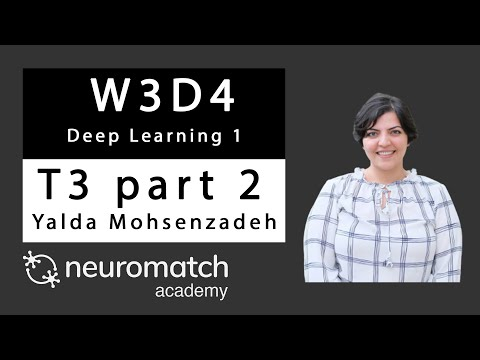

In [2]:
#@title Video 2: Quantitative comparisons of CNNs and neural activity
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="2Jbk7jFBvbU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 2:

- look at the activations of units in the neural network and compare it with the
brain neuron's activations.

- brain neurons in Region V 1 shows selectivity to some specific orientation.
Model units in pooling layer also show kind of a similar property - highly selective to this specific orientation.
More interestingly, units in model fully connected layers show a categorical selectivity - selective to some specific orientations, but not others.
The question is how we can quantitatively measure this similarity between brain neurons and model neurons.
-One approach is to use representational similarity analysis and the idea here is that
for any pair of stimuli in the stimulus set, you extract the neural activity pattern,
and then compute a dissimilarity measure between them which could be different distance measures.
- Here, we are going to use (1 - correlation coefficient) and then we construct a matrix,
in which each row and column of this matrix is indexed by one of the stimuli in the stimulus set.
You would assign the dissimilarity measure between each pair of stimuli to an element,
which is next with their corresponding stimulus.
This matrix is called Representational Dissimilarity Matrix.
- With Representational Similarity Analysis,
you would first extract activation patterns from each layer of the network then compute their dissimilarities,
and create an RDM. So, you can create an RDM for each layer of the model.
- In a similar way, you would expect a neural activity pattern from brain region V1,
and then compute their pairwise dissimilarities and create an RDM from V1.
- Now, that the data is mapped to a common space of R_n,
it's easy to compare them by just simply computing their correlation of these RDNs.
- Here, you can see the correlation coefficient for comparing model pooling layer RDM
with V1 brain RDM and model fully connected layer RDM with brain V1 RDM.
- As you would expect, the correlation is higher for pooling layer compared to fully connected layer.
Representation Similarity Analysis is a powerful method because it Maps the data from different modalities
to the common space, where they can be directly compared and you can find their similarities.
- For example, you can compute RDM from brain data, from neural network activity patterns,
from image pixels themselves, or even from the behavioural data.
- For example, in the orientation discrimination task, you can create an RDM by comparing reaction times
to each stimuli,
and then compare it with brain data or by neural network data.

### Section 3.2.1 Representational Similarity Analysis (RSA)

We noticed above some similarities and differences between the population responses in mouse primary visual cortex and in different layers in our model. Let's now try to quantify this.

To do this, we'll use a technique called [**Representational Similarity Analysis**](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research). The idea is to look at the similarity structure between representations of different stimuli. We can say that a brain area and a model use a similar representational scheme if stimuli that are represented (dis)similarly in the brain are represented (dis)similarly in the model as well.

To quantify this, we begin by computing the **representational dissimilarity matrix (RDM)** for the mouse V1 data and each model layer. This matrix, which we'll call $\mathbf{M}$, is computed as one minus the correlation coefficients between population responses to each stimulus. We can  efficiently compute this by using the $z$-scored responses (see Appendix for explanation). In particular, the full matrix can be computed as:
\begin{gather}
  \mathbf{M} = 1 - \frac{1}{N} \mathbf{ZZ}^T \\
\end{gather}

where $\mathbf{Z}$ is the z-scored responses and N is the number of neurons (or units).

 

#### Exercise 1: Compute RDMs

Complete the function `RDM()` for computing the RDM for a given set of population responses to each stimulus. Use the above formula in terms of $z$-scored population responses. You can use the helper function `zscore()` to compute the matrix of $z$-scored responses.

The subsequent cell uses this function to plot the RDM of the population responses in the V1 data and in each layer of our model CNN.



In [ ]:
def RDM(resp):
  """Compute the representational dissimilarity matrix (RDM)

  Args:
    resp (ndarray): S x N matrix with population responses to
      each stimulus in each row

  Returns:
    ndarray: S x S representational dissimilarity matrix
  """
  #########################################################
  ## TO DO for students: compute representational dissimilarity matrix
  # Fill out function and remove
  raise NotImplementedError("Student exercise: complete function RDM")
  #########################################################

  # z-score responses to each stimulus
  zresp = ...

  # Compute RDM
  RDM = ...

  return RDM


# Uncomment to test your function
# rdm_dict = {label: RDM(resp) for label, resp in resp_dict.items()}
# plot_multiple_rdm(rdm_dict)

In [ ]:
# to_remove solution
def RDM(resp):
  """Compute the representational dissimilarity matrix (RDM)

  Args:
    resp (ndarray): S x N matrix with population responses to
      each stimulus in each row

  Returns:
    ndarray: S x S representational dissimilarity matrix
  """

  # z-score responses to each stimulus
  zresp = zscore(resp, axis=1)

  # Compute RDM
  RDM = 1 - (zresp @ zresp.T) / zresp.shape[1]

  return RDM

rdm_dict = {label: RDM(resp) for label, resp in resp_dict.items()}
with plt.xkcd():
  plot_multiple_rdm(rdm_dict)

Video available at https://youtube.com/watch?v=otzR-KXDjus


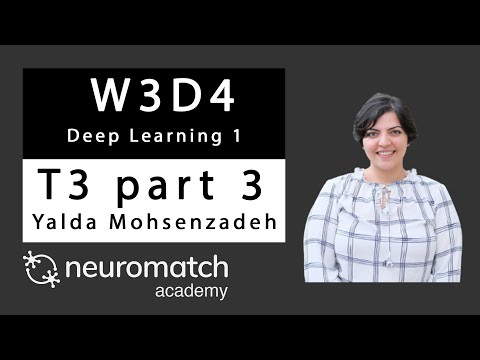

In [3]:
#@title Video 3: Exercise 1 solution discussion
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="otzR-KXDjus", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

# Summary of Video 3:

- First, you would standardize your neural activity responses by computing the z-score of these responses,
which is basically normalizing of the mean and standard deviation and then computing 1 - correlation of these
z-score responses.
This will give you for this orientation discrimination task a 180 by 180 matrix - RDM.
This matrix is square shaped, symmetric, and its diagonal is zero.
Here, you can see the RDMs from the orientation discrimination task
which is computed from brain data,
and from model pooling layer activations and from model fully connected layer activations.
- the pooling layer RDM shows more similar structure to V1 RDM
Fully connected layer rdm shows a categorical structure meaning that 
basically this part of the RDM which corresponds to an orientation to the left, are more similar,
and similarly, those oriented to the right are more similar,
but they are more distant or apart from each other clear categorical structure.


#### (Bonus) Exercise: Correlate RDMs

To quantify how similar the representations are, we can simply correlate their dissimilarity matrices. For this, we'll again use the correlation coefficient. Note that dissimilarity matrices are symmetric ($M_{ss'} = M_{s's}$), so we should only use the off-diagonal terms on one side of the diagonal when computing this correlation to avoid overcounting. Moreover, we should leave out the diagonal terms, which are always equal to 0, so will always be perfectly correlated across any pair of RDM's.

Complete the function `correlate_rdms()` below that computes this correlation. The code for extracting the off-diagonal terms is provided.

We will then use function to compute the correlation between the RDM's for each layer of our model CNN and that of the V1 data. 

In [ ]:
def correlate_rdms(rdm1, rdm2):
  """Correlate off-diagonal elements of two RDM's

  Args:
    rdm1 (np.ndarray): S x S representational dissimilarity matrix
    rdm2 (np.ndarray): S x S representational dissimilarity matrix to
      correlate with rdm1

  Returns:
    float: correlation coefficient between the off-diagonal elements
      of rdm1 and rdm2

  """

  # Extract off-diagonal elements of each RDM
  ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
  rdm1_offdiag = rdm1[ioffdiag]
  rdm2_offdiag = rdm2[ioffdiag]

  #########################################################
  ## TO DO for students: compute correlation coefficient
  # Fill out function and remove
  raise NotImplementedError("Student exercise: complete correlate rdms")
  #########################################################
  corr_coef = np.corrcoef(..., ...)[0,1]

  return corr_coef


# Split RDMs into V1 responses and model responses
rdm_model = rdm_dict.copy()
rdm_v1 = rdm_model.pop('V1 data')

# Correlate off-diagonal terms of dissimilarity matrices
# Uncomment below to test your function
# rdm_sim = {label: correlate_rdms(rdm_v1, rdm) for label, rdm in rdm_model.items()}
# plot_rdm_rdm_correlations(rdm_sim)

In [ ]:
# to_remove solution
def correlate_rdms(rdm1, rdm2):
  """Correlate off-diagonal elements of two RDM's

  Args:
    rdm1 (np.ndarray): S x S representational dissimilarity matrix
    rdm2 (np.ndarray): S x S representational dissimilarity matrix to
      correlate with rdm1

  Returns:
    float: correlation coefficient between the off-diagonal elements
      of rdm1 and rdm2

  """

  # Extract off-diagonal elements of each RDM
  ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
  rdm1_offdiag = rdm1[ioffdiag]
  rdm2_offdiag = rdm2[ioffdiag]

  corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]

  return corr_coef


# Split RDMs into V1 responses and model responses
rdm_model = rdm_dict.copy()
rdm_v1 = rdm_model.pop('V1 data')

# Correlate off-diagonal terms of dissimilarity matrices
rdm_sim = {label: correlate_rdms(rdm_v1, rdm) for label, rdm in rdm_model.items()}
with plt.xkcd():
  plot_rdm_rdm_correlations(rdm_sim)

According to this metric, which layer's representations most resemble those in the data? Does this agree with your intuitions from exercise 3?

#### (Bonus) Exercise: Plot rows of RDM

To better understand how these correlations in RDM's arise, we can try plotting individual rows of the RDM matrix. The resulting curves show the similarity of the responses to each stimulus with that to one specific stimulus.

Complete the `plot_rdm_rows()` function below for plotting the rows of the model and data RDM's. We will then plot a few specified rows. Do these curves explain the correlation (or lack thereof) in RDM's you saw in the previous exercise?

In [ ]:
def plot_rdm_rows(ori_list, rdm_dict, rdm_oris):
  """Plot the dissimilarity of response to each stimulus with response to one
  specific stimulus

  Args:
    ori_list (list of float): plot dissimilarity with response to stimulus with
      orientations closest to each value in this list
    rdm_dict (dict): RDM's from which to extract dissimilarities
    rdm_oris (np.ndarray): orientations corresponding to each row/column of RDMs
    in rdm_dict

  """
  n_col = len(ori_list)
  f, axs = plt.subplots(1, n_col, figsize=(4 * n_col, 4), sharey=True)

  # Get index of orientation closest to ori_plot
  for ax, ori_plot in zip(axs, ori_list):
    iori = np.argmin(np.abs(rdm_oris - ori_plot))

    ######################################################################
    # TODO: plot dissimilarity curves in each RDM and remove the error
    raise NotImplementedError("Student exercise: complete plot_rdm_rows")
    ######################################################################

    # Plot dissimilarity curves in each RDM
    for label, rdm in rdm_dict.items():
      ax.plot(..., ..., label=label)

    # Draw vertical line at stimulus we are plotting dissimilarity w.r.t.
    ax.axvline(rdm_oris[iori], color=".7", zorder=-1)

    # Label axes
    ax.set_title(f'Dissimilarity with response\nto {ori_plot: .0f}$^o$ stimulus')
    ax.set_xlabel('Stimulus orientation ($^o$)')

  axs[0].set_ylabel('Dissimilarity')
  axs[-1].legend(loc="upper left", bbox_to_anchor=(1, 1))


ori_list = [-75, -25, 25, 75]

# Uncomment to test your function
# plot_rdm_rows(ori_list, rdm_dict, ori)

In [ ]:
# to_remove solution
def plot_rdm_rows(ori_list, rdm_dict, rdm_oris):
  """Plot the dissimilarity of response to each stimulus with response to one
  specific stimulus

  Args:
    ori_list (list of float): plot dissimilarity with response to stimulus with
      orientations closest to each value in this list
    rdm_dict (dict): RDM's from which to extract dissimilarities
    rdm_oris (np.ndarray): orientations corresponding to each row/column of RDMs
    in rdm_dict

  """
  n_col = len(ori_list)
  f, axs = plt.subplots(1, n_col, figsize=(4 * n_col, 4), sharey=True)

  # Get index of orientation closest to ori_plot
  for ax, ori_plot in zip(axs, ori_list):
    iori = np.argmin(np.abs(rdm_oris - ori_plot))

    # Plot dissimilarity curves in each RDM
    for label, rdm in rdm_dict.items():
      ax.plot(rdm_oris, rdm[iori, :], label=label)

    # Draw vertical line at stimulus we are plotting dissimilarity w.r.t.
    ax.axvline(rdm_oris[iori], color=".7", zorder=-1)

    # Label axes
    ax.set_title(f'Dissimilarity with response\nto {ori_plot: .0f}$^o$ stimulus')
    ax.set_xlabel('Stimulus orientation ($^o$)')

  axs[0].set_ylabel('Dissimilarity')
  axs[-1].legend(loc="upper left", bbox_to_anchor=(1, 1))


ori_list = [-75, -25, 25, 75]
with plt.xkcd():
  plot_rdm_rows(ori_list, rdm_dict, ori)

## Section 3.3: Qualitative comparisons of CNNs and neural activity

To visualize the representations in the data and in each of these model layers, we'll use two classic techniques from systems neuroscience:

1. **tuning curves**: plotting the response of single neurons (or units, in the case of the deep network) as a function of the stimulus orientation

2. **dimensionality reduction**: plotting full population responses to each stimulus in two dimensions via dimensionality reduction. We'll use the non-linear dimensionality reduction technique t-SNE for this.

### Section 3.3.1: Tuning curves

Below, we show some example tuning curves for different neurons and units in the CNN we trained above. How are the single neuron responses similar/different between the model and the data? Try running this cell multiple times to get an idea of shared properties in the tuning curves of the neurons within each population.



In [ ]:
#@title
#@markdown Execute this cell to visualize tuning curves

fig, axs = plt.subplots(1, len(resp_dict), figsize=(len(resp_dict) * 6, 6))

for i, (label, resp) in enumerate(resp_dict.items()):

  ax = axs[i]
  ax.set_title('%s responses' % label)

  # Pick three random neurons whose tuning curves to plot
  ineurons = np.random.choice(resp.shape[1], 3, replace=False)

  # Plot tuning curves of ineurons
  ax.plot(ori, resp[:, ineurons])

  ax.set_xticks(np.linspace(-90, 90, 5))
  ax.set_xlabel('stimulus orientation')
  ax.set_ylabel('neural response')

plt.tight_layout()
plt.show()

### Section 3.3.2: Dimensionality reduction of representations

We can visualize a dimensionality-reduced version of the internal representations of the mouse primary visual cortex or CNN internal representations in order to potentially uncover informative structure. Here, we use PCA to reduce the dimensionality to 20 dimensions, and then use tSNE to further reduce dimensionality to 2 dimensions. We use the first step of PCA so that tSNE runs faster.

#### (Bonus) Exercise: Visualize reduced dimensionality representations

Complete the code below for plotting dimensionality-reduced population responses. 





In [ ]:
def plot_resp_lowd(resp_dict):
    """Plot a low-dimensional representation of each dataset in resp_dict."""
    n_col = len(resp_dict)
    fig, axs = plt.subplots(1, n_col, figsize=(4.5 * len(resp_dict), 4.5))
    for i, (label, resp) in enumerate(resp_dict.items()):

      ax = axs[i]
      ax.set_title('%s responses' % label)

      # First do PCA to reduce dimensionality to 20 dimensions so that tSNE is faster
      resp_lowd = PCA(n_components=min(20, resp.shape[1])).fit_transform(resp)

      # Then do tSNE to reduce dimensionality to 2 dimensions
      resp_lowd = TSNE(n_components=2).fit_transform(resp_lowd)

      #########################################################################
      # TODO: plot dimensionality-reduced responses and remove the error
      raise NotImplementedError("Student exercise: complete plot_resp_lowd")
      #########################################################################
      # Plot dimensionality-reduced population responses
      # on 2D axes, with each point colored by stimulus orientation
      x, y = ..., ...
      pts = ax.scatter(x, y, c=ori, cmap='twilight', vmin=-90, vmax=90)
      fig.colorbar(pts, ax=ax, ticks=np.linspace(-90, 90, 5), label='Stimulus orientation')

      ax.set_xlabel('Dimension 1')
      ax.set_ylabel('Dimension 2')
      ax.set_xticks([])
      ax.set_yticks([])


# Uncomment to test your function
# plot_resp_lowd(resp_dict)

In [ ]:
# to_remove solution
def plot_resp_lowd(resp_dict):
    """Plot a low-dimensional representation of each dataset in resp_dict."""
    n_col = len(resp_dict)
    fig, axs = plt.subplots(1, n_col, figsize=(4.5 * len(resp_dict), 4.5))
    for i, (label, resp) in enumerate(resp_dict.items()):

      ax = axs[i]
      ax.set_title('%s responses' % label)

      # First do PCA to reduce dimensionality to 20 dimensions so that tSNE is faster
      resp_lowd = PCA(n_components=min(20, resp.shape[1])).fit_transform(resp)

      # Then do tSNE to reduce dimensionality to 2 dimensions
      resp_lowd = TSNE(n_components=2).fit_transform(resp_lowd)

      # Plot dimensionality-reduced population responses
      # on 2D axes, with each point colored by stimulus orientation
      x, y = resp_lowd[:, 0], resp_lowd[:, 1]
      pts = ax.scatter(x, y, c=ori, cmap='twilight', vmin=-90, vmax=90)
      fig.colorbar(pts, ax=ax, ticks=np.linspace(-90, 90, 5), label='Stimulus orientation')

      ax.set_xlabel('Dimension 1')
      ax.set_ylabel('Dimension 2')
      ax.set_xticks([])
      ax.set_yticks([])

with plt.xkcd():
  plot_resp_lowd(resp_dict)

Interpret the figure above. Why do these representations look the way they do? Here are a few specific questions to think about:
  * How are the population responses similar/different between the model and the data? Can you explain these population-level responses from the single neuron responses seen in the previous exercise, or vice-versa?
  * How do the representations in the different layers of the model differ, and how does this relate to the orientation discrimination task the model was optimized for?
  * Which layer of our deep network encoding model most closely resembles the V1 data?

*HINTS*:

1. Think of comparison between model and the data in terms of its peaks. What would happen if we tried t-SNE embedding?
2. Compare across the pool layer and fc layer - what do they represent. How do they appear to be clustered?

In [ ]:
# to_remove explanation

"""
The single unit activations of the 'pool' layer in the model have peaks at various
orientations, but they appear to have more peaks than the tuning curves from the
original data do. When we look at the population level responses we see that they
are not quite as smooth across orientations in the t-SNE embedding, which is likely
due to the fact that the 'pool' layer activations do not have localized responses
to orientations like the neural data.

The representations in the fully-connected 'fc' layer appear to be much more
clustered than the 'pool' layer. Stimuli which correspond to the same choice are
clustered together. It seems like the 'pool' layer is still working hard to
represent information about the orientation of the stimulus (much like the V1
population), whereas the 'fc' layer only cares about tilt category, representing
all the stimuli with the same category in a similar way regardless of their different
orientations.

From this analysis, it appears that the 'pool' layer is more similar to the neural
data at the population level.

""";

---
# Summary

In this notebook, we learned 
* how to use deep learning to build a normative encoding model of the visual system
* how to use RSA to evaluate how the model's representations match to those in the brain

Our approach was to optimize a deep convolutional network to solve an orientation discrimination task. But note that many other approaches could have been taken.

Firstly, there are many other "normative" ways to solve this orientation discrimination task. We could have used different neural network architectures, or even used a completely different algorithm that didn't involve a neural network at all, but instead used other kinds of image transformations (e.g. Fourier transforms). Neural network approaches, however, are special in that they explicitly uses abstract distributed representations to compute, which feels a lot closer to the kinds of algorithms the brain uses. See the appendix for a deeper discussion of why *convolutional* neural networks in particular are well-suited for building normative models of the visual system.

Secondly, our choice of visual task was mostly arbitrary. For example, we could have trained our network to directly estimate the orientation of the stimulus, rather than just discriminating between two classes of tilt. Or, we could have trained the network to perform a more naturalistic task, such as recognizing the rotation of an arbitrary image. Or we could try a task like object recognition. Is this something that mice compute in their visual cortex?

Training on different tasks could lead to different representations of the oriented grating stimuli, which might match the observed V1 representations better or worse.

---
# Appendix

## Convolutional Neural Networks (CNN's)

Convolutional layers are different from their fully connected counterparts in two ways (see figure below):
  * In a fully connected layer, each unit computes a weighted sum over all the input units. In a convolutional layer, on the other hand, each unit computes a weighted sum over only a small patch of the input, referred to as the unit's **receptive field**. When the input is an image, the receptive field can be thought of as a local patch of pixels.
  * In a fully connected layer, each unit uses its own independent set of weights to compute the weighted sum. In a convolutional layer, all the units (within the same channel) **share the same weights**. This set of shared weights is called the **convolutional filter or kernel**. The result of this computation is a convolution, where each unit has computed the same weighted sum over a different part of the input.

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/weight-sharing.png?raw=true" width="700" />
</p>

## Building CNN's with PyTorch

Here we walk through building the different types of layers in a CNN using PyTorch, culminating in the CNN model used above.

#### **Fully connected layers**

In a fully connected layer, each unit computes a weighted sum over all the input units and applies a non-linear function to this weighted sum. You have used such layers many times already in parts 1 and 2. As you have already seen, these are implemented in PyTorch using the `nn.Linear` class.

  See the next cell for code for constructing a deep network with one fully connected layer that will classify an input image as being tilted left or right. Specifically, its output is the predicted probability of the input image being tilted right. To ensure that its output is a probability (i.e. a number between 0 and 1), we use a sigmoid activation function to squash the output into this range (implemented with `torch.sigmoid()`).

In [ ]:
class FC(nn.Module):
  """Deep network with one fully connected layer

    Args:
      h_in (int): height of input image, in pixels (i.e. number of rows)
      w_in (int): width of input image, in pixels (i.e. number of columns)

    Attributes:
      fc (nn.Linear): weights and biases of fully connected layer
      out (nn.Linear): weights and biases of output layer

    """

  def __init__(self, h_in, w_in):
    super().__init__()
    self.dims = h_in * w_in  # dimensions of flattened input
    self.fc = nn.Linear(self.dims, 10)  # flattened input image --> 10D representation
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
      x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
          each of p stimulus images.

    Returns:
      torch.Tensor: p x 1 tensor with network outputs for each input provided
          in x. Each output should be interpreted as the probability of the
          corresponding stimulus being tilted right.

    """
    x = x.view(-1, self.dims)  # flatten each input image into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x

#### **Convolutional layers**

In a convolutional layer, each unit computes a weighted sum over a two-dimensional $K \times K$ patch of inputs (see appendix for a more detailed description). As we saw in part 2, the units are arranged in **channels** (see figure below), whereby units in the same channel compute the same weighted sum over different parts of the input, using the weights of that channel's **convolutional filter (or kernel)**. The output of a convolutional layer is thus a three-dimensional tensor of shape $C^{out} \times H \times W$, where $C^{out}$ is the number of channels (i.e. the number of convolutional filters/kernels), and $H$ and $W$ are the height and width of the input.

  <p align="center">
    <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/convnet.png?raw=true" width="350" />
  </p>

Such layers can be implemented in Python using the PyTorch class `nn.Conv2d`, which takes the same arguments as `nn.Conv1d` (documentation [here](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)).
  
See the next cell for code incorporating a convolutional layer with 8 convolutional filters of size 5 $\times$ 5 into our above fully connected network. Note that we have to flatten the multi-channel output in order to pass it on to the fully connected layer.

**Note:** as is also the case for the `nn.Conv1d` class, the inputs to `nn.Conv2d` layers must have a channel dimension in their first dimension. Thus, the input to a `nn.Conv2d` layer must be a 3D tensor of shape $C^{in} \times H \times W$ where $C^{in}$ is the number of input channels and $H, W$ their height and width, respectively. This means we'll have to make sure the stimulus images we feed into our network are 3D as well, like RGB images are. We'll do this by simply appending a singleton dimension, to reflect the fact that our grayscale images have a single color channel.

In [ ]:
class ConvFC(nn.Module):
  """Deep network with one convolutional layer and one fully connected layer

  Args:
    h_in (int): height of input image, in pixels (i.e. number of rows)
    w_in (int): width of input image, in pixels (i.e. number of columns)

  Attributes:
    conv (nn.Conv2d): filter weights of convolutional layer
    dims (tuple of ints): dimensions of output from conv layer
    fc (nn.Linear): weights and biases of fully connected layer
    out (nn.Linear): weights and biases of output layer

  """

  def __init__(self, h_in, w_in):
    super().__init__()
    C_in = 1  # input stimuli have only 1 input channel
    C_out = 8  # number of output channels (i.e. of convolutional kernels to convolve the input with)
    K = 5  # size of each convolutional kernel (should be odd number for the padding to work as expected)
    self.conv = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)  # add padding to ensure that each channel has same dimensionality as input
    self.dims = (C_out, h_in, C_out)  # dimensions of conv layer output
    self.fc = nn.Linear(np.prod(self.dims), 10)  # flattened conv output --> 10D representation
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
      x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
          each of p stimulus images.

    Returns:
      torch.Tensor: p x 1 tensor with network outputs for each input provided
          in x. Each output should be interpreted as the probability of the
          corresponding stimulus being tilted right.

    """
    x = x.unsqueeze(1)  # p x 1 x 48 x 64, add a singleton dimension for the single stimulus channel
    x = torch.relu(self.conv(x))  # output of convolutional layer
    x = x.view(-1, np.prod(self.dims))  # flatten convolutional layer outputs into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x

#### **Max pooling layers**

In a max pooling layer, each unit computes the maximum over a small two-dimensional $K^{pool} \times K^{pool}$ patch of inputs. Given a multi-channel input of dimensions $C \times H \times W$, the output of a max pooling layer has dimensions $C \times H^{out} \times W^{out}$, where:
\begin{align}
  H^{out} &= \left\lfloor \frac{H}{K^{pool}} \right\rfloor\\
  W^{out} &= \left\lfloor \frac{W}{K^{pool}} \right\rfloor
\end{align}
where $\lfloor\cdot\rfloor$ denotes rounding down to the nearest integer below (i.e. floor division `//` in Python).

  Max pooling layers can be implemented with the PyTorch `nn.MaxPool2d` class, which takes as a single argument the size $K^{pool}$ of the pooling patch. See the next cell for an example, which builds upon the previous example by adding in a max pooling layer just after the convolutional layer. Note again that we need to calculate the dimensions of its output in order to set the dimensions of the subsequent fully connected layer.

In [ ]:
class PoolConvFC(nn.Module):
  """Deep network with one convolutional layer followed by a max pooling layer
  and one fully connected layer

  Args:
    h_in (int): height of input image, in pixels (i.e. number of rows)
    w_in (int): width of input image, in pixels (i.e. number of columns)

  Attributes:
    conv (nn.Conv2d): filter weights of convolutional layer
    pool (nn.MaxPool2d): max pooling layer
    dims (tuple of ints): dimensions of output from pool layer
    fc (nn.Linear): weights and biases of fully connected layer
    out (nn.Linear): weights and biases of output layer

  """

  def __init__(self, h_in, w_in):
    super().__init__()
    C_in = 1  # input stimuli have only 1 input channel
    C_out = 8  # number of output channels (i.e. of convolutional kernels to convolve the input with)
    K = 5  # size of each convolutional kernel
    Kpool = 2  # size of patches over which to pool
    self.conv = nn.Conv2d(C_in, C_out, kernel_size=K, padding=K//2)  # add padding to ensure that each channel has same dimensionality as input
    self.pool = nn.MaxPool2d(Kpool)
    self.dims = (C_out, h_in // Kpool, w_in // Kpool)  # dimensions of pool layer output
    self.fc = nn.Linear(np.prod(self.dims), 10)  # flattened pool output --> 10D representation
    self.out = nn.Linear(10, 1)  # 10D representation --> scalar

  def forward(self, x):
    """Classify grating stimulus as tilted right or left

    Args:
      x (torch.Tensor): p x 48 x 64 tensor with pixel grayscale values for
          each of p stimulus images.

    Returns:
      torch.Tensor: p x 1 tensor with network outputs for each input provided
          in x. Each output should be interpreted as the probability of the
          corresponding stimulus being tilted right.

    """
    x = x.unsqueeze(1)  # p x 1 x 48 x 64, add a singleton dimension for the single stimulus channel
    x = torch.relu(self.conv(x))  # output of convolutional layer
    x = self.pool(x)  # output of pooling layer
    x = x.view(-1, np.prod(self.dims))  # flatten pooling layer outputs into a vector
    x = torch.relu(self.fc(x))  # output of fully connected layer
    x = torch.sigmoid(self.out(x))  # network output
    return x

This pooling layer completes the CNN model trained above to perform orientation discrimination. We can think of this architecture as having two primary layers:
1. a convolutional + pooling layer
2. a fully connected layer

We group together the convolution and pooling layers into one, as they really form one full unit of convolutional processing, where each patch of the image is passed through a convolutional filter and pooled with neighboring patches. It is standard practice to follow up any convolutional layer with a pooling layer, so they are generally treated as a single block of processing.

## Orientation discrimination as a binary classification problem

What loss function should we minimize to optimize orientation discrimination performance? We first note that the orientation discrimination task is a **binary classification problem**, where the goal is to classify a given stimulus into one of two classes: being tilted left or being tilted right. 

Our goal is thus to output a high probability of the stimulus being tilted right (i.e. large $p$) whenever the stimulus is tilted right, and a high probability of the stimulus being tilted left (i.e. large $1-p \Leftrightarrow$ small $p$) whenever the stimulus is tilted left.

Let $\tilde{y}^{(n)}$ be the label of the $n$th stimulus in the mini-batch, indicating its true tilt:
\begin{equation}
  \tilde{y}^{(n)} =
  \begin{cases}
    1 &\text{if stimulus }n\text{ is tilted right} \\
    0 &\text{if stimulus }n\text{ is tilted left}
  \end{cases}
\end{equation}
Let $p^{(n)}$ be the predicted probability of that stimulus being tilted right assigned by our network. Note that that $1-p^{(n)}$ is the predicted probability of that stimulus being tilted left. We'd now like to modify the parameters so as to maximize the predicted probability of the true class $\tilde{y}^{(n)}$. One way to formalize this is as maximizing the *log* probability
\begin{align}
  \log \left( \text{predicted probability of stimulus } n \text{ being of class } \tilde{y}^{(n)}\right) &= 
  \begin{cases}
    \log p^{(n)} &\text{if }\tilde{y}^{(n)} = 1 \\
    \log (1 - p^{(n)}) &\text{if }\tilde{y}^{(n)} = 0
  \end{cases}
  \\
  &= \tilde{y}^{(n)} \log p^{(n)} + (1 - \tilde{y}^{(n)})\log(1 - p^{(n)})
\end{align}
You should recognize this expression as the log likelihood of the Bernoulli distribution under the predicted probability $p^{(n)}$. This is the same quantity that is maximized in logistic regression, where the predicted probability $p^{(n)}$ is just a simple linear sum of its inputs (rather than a complicated non-linear operation, like in the deep networks used here).

To turn this into a loss function, we simply multiply it by -1, resulting in the so-called **binary cross-entropy**, or **negative log likelihood**. Summing over $P$ samples in a batch, the binary cross entropy loss is given by
\begin{equation}
  L = -\sum_{n=1}^P \tilde{y}^{(n)} \log p^{(n)} + (1 - \tilde{y}^{(n)})\log(1 - p^{(n)})
\end{equation}
The binary cross-entropy loss can be implemented in PyTorch using the `nn.BCELoss()` loss function (cf. [documentation](https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html)). 

Feel free to check out the code used to optimize the CNN in the `train()` function defined in the hidden cell of helper functions at the top of the notebook. Because the CNN's used here have lots of parameters, we have to use two tricks that we didn't use in the previous parts of this tutorial:
1. We have to use *stochastic* gradient descent (SGD), rather than just gradient descent (GD).
2. We have to use [momentum](https://distill.pub/2017/momentum/) in our SGD updates. This is easily incorporated into our PyTorch implementation by just setting the `momentum` argument of the built-in `optim.SGD` optimizer.

## RDM Z-Score Explanation

If $r^{(s)}_i$ is the response of the $i$th neuron to the $s$th stimulus, then
\begin{gather}
  M_{ss'} = 1 - \frac{\text{Cov}\left[ r_i^{(s)}, r_i^{(s')} \right]}{\sqrt{\text{Var}\left[ r_i^{(s)} \right] \text{Var}\left[ r_i^{(s')} \right]}} = 1 - \frac{\sum_{i=1}^N (r_i^{(s)} - \bar{r}^{(s)})(r_i^{(s')} - \bar{r}^{(s')}) }{\sqrt{\sum_{i=1}^N \left( r_i^{(s)} - \bar{r}^{(s)} \right)^2 \sum_{i=1}^N \left( r_i^{(s')} - \bar{r}^{(s')} \right)^2 }} \\
  \bar{r}^{(s)} = \frac{1}{N} \sum_{i=1}^N r_i^{(s)}
\end{gather}
This can be computed efficiently by using the $z$-scored responses
\begin{equation}
  z_i^{(s)} = \frac{r_i^{(s)} - \bar{r}^{(s)}}{\sqrt{\frac{1}{N}\sum_{i=1}^N \left( r_i^{(s)} - \bar{r}^{(s)} \right)^2}} \Rightarrow M_{ss'} = 1 - \frac{1}{N}\sum_{i=1}^N z_i^{(s)}z_i^{(s')}
\end{equation}
such that the full matrix can be computed through the matrix multiplication
\begin{gather}
  \mathbf{M} = 1 - \frac{1}{N} \mathbf{ZZ}^T \\
  \mathbf{Z} = 
  \begin{bmatrix}
    z_1^{(1)} & z_2^{(1)} & \ldots & z_N^{(1)} \\
    z_1^{(2)} & z_2^{(2)} & \ldots & z_N^{(2)} \\
    \vdots & \vdots & \ddots & \vdots \\
    z_1^{(S)} & z_2^{(S)} & \ldots & z_N^{(S)}
  \end{bmatrix}
\end{gather}


where $S$ is the total number of stimuli. Note that $\mathbf{Z}$ is an $S \times N$ matrix, and $\mathbf{M}$ is an $S \times S$ matrix.